# Data Pre Processing #

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [253]:
df1 = pd.read_csv("Combined/PR_audacity_combined.csv")
df2 = pd.read_csv("Combined/PR_jabref_combined.csv")
df3 = pd.read_csv("Combined/PR_powertoys_combined.csv")
df4 = pd.read_csv("Combined/PR_ant-design_combined.csv")
df5 = pd.read_csv("Combined/PR_bticoin_combined.csv")
df6 = pd.read_csv("Combined/PR_flutter_combined.csv")
df7 = pd.read_csv("Combined/PR_freeCodeCamp_combined.csv")
df8 = pd.read_csv("Combined/PR_langchain_combined.csv")
df9 = pd.read_csv("Combined/PR_mrdoob_combined.csv")
df10 = pd.read_csv("Combined/PR_node_combined.csv")
df11 = pd.read_csv("Combined/PR_playwright_combined.csv")
df12 = pd.read_csv("Combined/PR_pytorch_combined.csv")
df13 = pd.read_csv("Combined/PR_rust_combined.csv")
df14 = pd.read_csv("Combined/PR_swift_combined.csv")
df15 = pd.read_csv("Combined/PR_transformers_combined.csv")


df1['repo'] = 1
df2['repo'] = 2
df3['repo'] = 3
df4['repo'] = 4
df5['repo'] = 5
df6['repo'] = 6
df7['repo'] = 7
df8['repo'] = 8
df9['repo'] = 9
df10['repo'] = 10
df11['repo'] = 11
df12['repo'] = 12
df13['repo'] = 13
df14['repo'] = 14
df15['repo'] = 15

#combine all the data
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15])

# Chcek date to ensure that it is unseen to LLM

In [254]:
#only use rows that have a created at date after 2024-07-18
df['created_at_check'] = pd.to_datetime(df['created_at'])
df = df[df['created_at_check'] > '2024-07-18']
df = df.drop(columns=['created_at_check'])


In [255]:
df.head()

,pr_number,created_at,merged_at,author,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,...,number_of_reviews_requested,number_of_revisions,number_of_milestones,dependency_changes,comment_authors,issue_comments_text,reviews_text,issue_text,review_comments,repo
0,7308,2024-09-10T13:07:38Z,2024-09-10T13:49:46Z,igorkorsukov,0,0,1,9,2,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
1,7303,2024-09-10T12:15:27Z,2024-09-10T12:42:48Z,igorkorsukov,0,0,1,9,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
2,7301,2024-09-10T10:27:20Z,2024-09-10T13:13:54Z,grliszas14,0,0,2,40,1,1,...,0,2,0,False,[],NaN,NaN,Resolves: https://github.com/audacity/audacity...,NaN,1
3,7288,2024-09-09T13:13:46Z,2024-09-09T14:53:04Z,LWinterberg,0,0,1,12,3,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
4,7295,2024-09-10T08:53:37Z,2024-09-10T09:58:23Z,grliszas14,0,0,1,2,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1


In [256]:
df.shape

(8169, 31)

In [257]:
#save to csv
#df.to_csv("Combined/PR_combined.csv.csv", index=False)

In [258]:
#reviews_text are also comments
# add the test from the two columns together

df['issue_comments_text'] = (
    df['issue_comments_text'].fillna('').astype(str) + 
    df['reviews_text'].fillna('').astype(str)
)
df.drop(columns=['reviews_text' ], inplace=True)


# Cleaning the data

## Feature Extraction/ Generation


In [259]:
#if comment_author isnt empty list then set comments to 1 else 0
df['comments'] = df['comment_authors'].apply(lambda x: 0 if x.count("'")==0 else 1)

#if comment_author isnt empty then count teh number of apostrophes an d divide that by 2 to get the number of comments as an integer
df['comment_author_number'] = df['comment_authors'].apply(lambda x: 0 if pd.isnull(x) else int(x.count("'")/2))

#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_text_wordiness'] = df['issue_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

In [260]:
#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_text_wordiness'] = df['issue_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

In [261]:
#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_comments_text_length'] = df['issue_comments_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

#now calcualte wordiness by dividing the number of words by the number of comments
df['issue_comments_text_wordiness'] = (df['issue_comments_text_length']/df['comment_author_number'])

#df.drop('issue_comments_text_length', inplace=True, axis=1)

In [262]:
# drop time_since_last_commit and test_coverage columns
df.drop(['time_since_last_commit', 'test_coverage','dependency_changes', 'number_of_linked_issues', 'number_of_milestones'], axis=1, inplace=True)

#divide review_duration and time to first reponse  by 3600 to get hours
df['review_duration'] = df['review_duration']/3600
df['time_to_first_response'] = df['time_to_first_response']/3600


In [263]:
#fill out the missing values with 0
df['time_to_first_response'] = df['time_to_first_response'].fillna(0)

#drop comment_authors column
df.drop(['comment_authors'], axis=1, inplace=True)


In [264]:
df['code_changes_ratio'] = df['lines_of_code_changed'] / df['number_of_files_changed']

#if code_changes_ratio is nan fill with 0
df['code_changes_ratio'] = df['code_changes_ratio'].fillna(0)


In [265]:
#create a copy of Data fram for LLM
df_llm = df.copy()


## Clean Labels

In [266]:
import pandas as pd

# List all the unique labels and account for each
labels_all = df['labels'].unique()

# Convert to DataFrame
labels_all = pd.DataFrame(labels_all, columns=['label'])

# Convert everything to lowercase
labels_all['label'] = labels_all['label'].str.lower()

# Remove unwanted characters
labels_all['label'] = labels_all['label'].str.replace(r'[\[\]"\']', '', regex=True)

# Drop empty labels after cleaning
labels_all = labels_all[labels_all['label'].str.strip() != '']

#remove right square brackets quotes
#labels_all = labels_all.apply(lambda x: x.str.replace('\,',','))

#Split labels that contain commas into separate entries
label_list = labels_all['label'].str.split(',\s*', expand=True).stack().reset_index(drop=True)

# Get unique values
unique_labels = label_list.unique().tolist()



<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_11759/2950420958.py:22: SyntaxWarning: invalid escape sequence '\s'
  label_list = labels_all['label'].str.split(',\s*', expand=True).stack().reset_index(drop=True)


In [267]:
labels_df = pd.DataFrame(columns=unique_labels)
labels_df['Original_labels'] = df['labels'] 
for label in unique_labels:
    labels_df[label] = labels_df['Original_labels'].apply(lambda x: 1 if label in x else 0)

#add a row that sums teh count for each column 
labels_df.loc['Total'] = labels_df.sum()

#drop the original labels column
labels_df.drop('Original_labels', axis=1, inplace=True)

#drop all columns with a total less than 10
labels_df = labels_df.loc[:, (labels_df.sum(axis=0) > 10)]

#drop total row
labels_df = labels_df.drop(['Total'])

#count teh number of 1s in each row and call teh column label_count
labels_df['label_count'] = labels_df.sum(axis=1)

#add labels_df['label_count'] to df_llm
df_llm['label_count'] = labels_df['label_count']


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_11759/3229227120.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  labels_df['label_count'] = labels_df.sum(axis=1)


In [268]:
#concatenate labels_df to the original dataframe
df = pd.concat([df.reset_index(drop=True), labels_df.reset_index(drop=True)], axis=1)

#drop the labels column
df.drop(['labels'], axis=1, inplace=True)


In [269]:
df.shape

(8169, 183)

In [270]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 1),  # less than 1 hour - group 1
    (df['Issue_Lifetime(hours)'] >= 1) & (df['Issue_Lifetime(hours)'] < 24), # between 1 hour and 1 days - group 2
    (df['Issue_Lifetime(hours)'] >= 24) & (df['Issue_Lifetime(hours)'] < 168),  # between 1 day1 and a week - group 3
    (df['Issue_Lifetime(hours)'] >= 168) & (df['Issue_Lifetime(hours)'] < 5040),  # between  week and a month - group 4
    (df['Issue_Lifetime(hours)'] >= 5040)  # more than a month - group 5
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4, 5]
group_dict={
    1: 'Less than 1 hour',
    2: 'Between 1 hour and 1 day',
    3: 'Between 1 day and a week',
    4: 'Between a week and a month',
    5: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

#add the issue lifetime to the df_llm
df_llm['Issue Lifetime'] = df['Issue Lifetime']


## Clean text

In [271]:
import re

def clean_review_comment(text):
    # If text is not a string (e.g. NaN), return an empty string
    if not isinstance(text, str):
        return ""
    
    # Remove code blocks (anything between triple backticks)
    text = re.sub(r'```[\s\S]*?```', ' ', text)
    # Remove inline code (anything between single backticks)
    text = re.sub(r'`[^`]*`', ' ', text)
    
    # Remove commit hashes (40-character hexadecimal strings)
    text = re.sub(r'\b[0-9a-f]{40}\b', ' ', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+', ' ', text)
    
    # Remove extra quotes (replace multiple quotes with a single quote)
    text = re.sub(r'"+', '"', text)
    
    # (Optional) Remove boilerplate phrases or common templates
    text = re.sub(r'(?im)^(Checklist:|Note:).*$', ' ', text)
    
    # Remove punctuation (if desired)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Keep only English words of length 2 or more
    tokens = re.findall(r'\b[A-Za-z]{2,}\b', text)
    
    # Join tokens back into a single cleaned string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


df['review_comments']=df['review_comments'].apply(clean_review_comment)
df['issue_comments_text'] = df['issue_comments_text'].apply(clean_review_comment)
df['issue_text'] = df['issue_text'].apply(clean_review_comment)

#add the issue comments text to the df_llm
df_llm['issue_comments_text'] = df['issue_comments_text']

#add the issue text to the df_llm
df_llm['issue_text'] = df['issue_text']

#add the review comments to the df_llm
df_llm['review_comments'] = df['review_comments']



# TFIDF

In [272]:
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack, csr_matrix
import nltk

 #nltk.download('punkt')  # ensure the tokenizer models are downloaded
#nltk.download('punkt_tab')

def nltk_tokenizer(text):
    return nltk.word_tokenize(text)


#create new dataframe
df_TFIDF = df[['issue_comments_text', 'issue_text', 'repo', 'Issue Lifetime', 'review_comments']].copy()

# Combine the issue text and comments text into a single column
df_TFIDF['all_text'] =  df_TFIDF['issue_text'] +' '+ df_TFIDF['issue_comments_text']

#df_TFIDF['issue_comments_text'] +' '+ df_TFIDF['review_comments']+ ' ' + 

#get the stem words in all_text
stemmer = PorterStemmer()
df_TFIDF['all_text'] = df_TFIDF['all_text'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()])
) 


# Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, tokenizer=nltk_tokenizer, token_pattern=None, stop_words='english', max_df=0.8,  min_df=0.2 )
tfidf.fit(df_TFIDF['all_text'])
text_tfidf = tfidf.transform(df_TFIDF['all_text'])

#  Convert the TF-IDF sparse matrix into a DataFrame.
#    Use the same index as df to ensure proper merging.
tfidf_df = pd.DataFrame(
    text_tfidf.toarray(), 
    columns=tfidf.get_feature_names_out(), 
    index=df.index
)


# 5. Merge the TF-IDF features back into the original df.
#    If you no longer need the raw text columns, you can drop them later.
df = pd.concat([df, tfidf_df], axis=1)



In [273]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features=1000, tokenizer=nltk_tokenizer, token_pattern=None, stop_words='english', max_df=0.8,  min_df=0.2)
count_vect.fit(df_TFIDF['all_text'])
text_count = count_vect.transform(df_TFIDF['all_text'])

# Convert to DataFrame
count_df = pd.DataFrame(
    text_count.toarray(), 
    columns=count_vect.get_feature_names_out(), 
    index=df.index
)

# Merge back into original dataframe
df = pd.concat([df.reset_index(drop=True), count_df.reset_index(drop=True)], axis=1)

#save to csv
df.to_csv("Combined/PR_combined1.csv", index=False)


In [274]:
df.shape

(8169, 299)

## Data Distribution ##

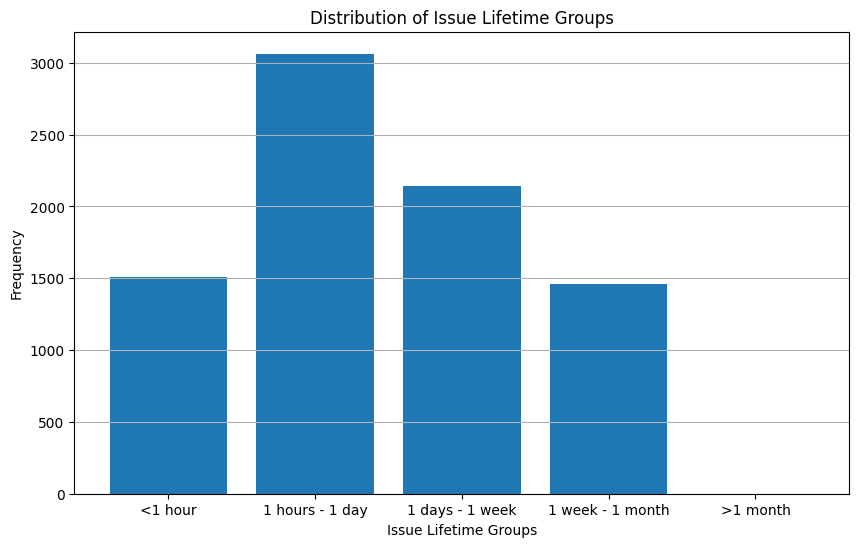

In [275]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

#if the group is empty then add it to the group counts and assign zero
for i in range(1, 6):
    if i not in group_counts.index:
        group_counts.loc[i] = 0

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<1 hour','1 hours - 1 day', '1 days - 1 week', '1 week - 1 month','>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

# More Feature Extraction


In [276]:
import pandas as pd

# Ensure 'created_at' and 'merged_at' are in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['merged_at'] = pd.to_datetime(df['merged_at'])

# Calculate 'Issues Opened in Last 2 Weeks' for each row depending on its repo
df['Issues Opened in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['created_at'] >= row['created_at'] - pd.Timedelta(days=14)) & 
                   (df['created_at'] < row['created_at']) & 
                   (df['repo'] == row['repo'])].shape[0], axis=1
)
# Calculate 'Issues Closed in Last 2 Weeks' for each row
df['Issues Closed in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['merged_at'] >= row['merged_at'] - pd.Timedelta(days=14)) & 
                   (df['merged_at'] < row['merged_at'])& 
                   (df['repo'] == row['repo'])].shape[0], axis=1
)

# Calculate 'Open PRs at Open Date' for each row
df['Open PRs at Open Date'] = df.apply(
    lambda row: df[(df['created_at'] < row['created_at']) & 
                   (df['merged_at'] > row['created_at'])& 
                   (df['repo'] == row['repo'])].shape[0], axis=1
)


In [277]:
# Reset the index to ensure it's unique
df = df.reset_index(drop=True)

# Calculate the number of PRs opened by the author before each PR's created_at date
df['Author PRs Opened'] = df.apply(
    lambda row: df[(df['author'] == row['author']) & 
                   (df['created_at'] < row['created_at'])& 
                   (df['repo'] == row['repo'])].shape[0], axis=1
)


In [278]:
#determien teh day ofthe week teh PR was created
df['day_of_week'] = df['created_at'].dt.dayofweek
#0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday

#for df['weekday'] set to 1 if day_of_week is between 0 and 4 else 0
df['weekday'] = df['day_of_week'].apply(lambda x: 1 if x >= 0 and x <= 4 else 0)


In [279]:
# add 'day_of_week', 'weekday', 'Author PRs Opened', 'Open PRs at Open Date', 'Issues Closed in Last 2 Weeks', 'Issues Opened in Last 2 Weeks' to df_llm
df_llm['day_of_week'] = df['day_of_week']
df_llm['weekday'] = df['weekday']
df_llm['Author PRs Opened'] = df['Author PRs Opened']
df_llm['Open PRs at Open Date'] = df['Open PRs at Open Date']
df_llm['Issues Closed in Last 2 Weeks'] = df['Issues Closed in Last 2 Weeks']
df_llm['Issues Opened in Last 2 Weeks'] = df['Issues Opened in Last 2 Weeks']


#drop the created_at and merged_at columns and author
df_llm.drop(['created_at', 'merged_at', 'author'], axis=1, inplace=True)




In [280]:
#save to csv
df_llm.to_csv("TtST_llm_tabular_text.csv", index=False)

In [281]:
#break

In [282]:
#check if the PR was created between 4pm and 9pm
#this si the period in time that most people are working across the US
#df['working_hours'] = df['created_at'].dt.hour.apply(lambda x: 1 if x >= 9 and x <= 21 else int(0))


In [283]:
#drop the created_at and merged_at columns and author
df.drop(['created_at', 'merged_at','author'], axis=1, inplace=True)

In [284]:
# List of columns to drop
columns_to_drop = ['review_comments', 'issue_text', 'issue_comments_text', 'comment_authors', 'reviews_text', 'review_duration']

for column in columns_to_drop:
    try:
        df.drop([column], axis=1, inplace=True)
    except KeyError:
        # Column not found, pass without raising an error
        pass


## Correlation Matrix ##

In [285]:
# Replace empty strings or invalid values with NaN
df.replace('', np.nan, inplace=True)

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
correlation_matrix

,pr_number,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,number_of_approvals,time_to_first_response,number_of_assignees,...,updat,use,wa,work,Issues Opened in Last 2 Weeks,Issues Closed in Last 2 Weeks,Open PRs at Open Date,Author PRs Opened,day_of_week,weekday
pr_number,1.000000,0.130965,-0.004872,-0.003935,0.005442,0.040116,-0.031392,-0.041998,0.016376,0.201677,...,-0.124787,0.066812,0.113152,-0.068731,0.441712,0.473692,0.256771,-0.021380,0.023201,-0.024157
number_of_comments,0.130965,1.000000,0.376442,0.188160,0.036728,0.081709,0.357650,0.150305,-0.007102,0.191299,...,0.202232,0.361084,0.460670,0.131411,-0.109864,0.043643,0.033320,-0.195217,0.042354,-0.064983
number_of_review_comments,-0.004872,0.376442,1.000000,0.302422,0.011662,0.029987,0.542531,0.198403,0.176806,0.073182,...,0.121975,0.211567,0.204914,0.066576,-0.136641,-0.043140,0.039818,-0.154650,0.014181,-0.017129
number_of_commits,-0.003935,0.188160,0.302422,1.000000,0.106632,0.274529,0.122401,-0.003312,0.109652,0.016777,...,0.193064,0.166321,0.110775,0.028345,-0.029488,0.005360,0.062218,-0.070152,0.008749,-0.006446
lines_of_code_changed,0.005442,0.036728,0.011662,0.106632,1.000000,0.400365,0.014695,0.004854,-0.002502,-0.010563,...,0.055926,0.008517,-0.002689,-0.003217,-0.024836,-0.021065,-0.028000,-0.012755,-0.004165,-0.000297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Issues Closed in Last 2 Weeks,0.473692,0.043643,-0.043140,0.005360,-0.021065,0.021441,-0.148377,-0.156078,-0.009175,0.211947,...,-0.086071,0.033166,0.036222,-0.054153,0.833999,1.000000,0.290218,0.012685,0.043628,-0.034056
Open PRs at Open Date,0.256771,0.033320,0.039818,0.062218,-0.028000,0.015885,0.068331,0.075487,0.026785,0.115113,...,0.037646,0.025936,0.123440,-0.089925,0.372306,0.290218,1.000000,-0.268184,0.001154,0.002161
Author PRs Opened,-0.021380,-0.195217,-0.154650,-0.070152,-0.012755,-0.018542,-0.222995,-0.173324,-0.083662,-0.110836,...,-0.066316,-0.053422,-0.151492,0.050879,0.062916,0.012685,-0.268184,1.000000,-0.025089,0.031089
day_of_week,0.023201,0.042354,0.014181,0.008749,-0.004165,0.003831,0.017167,0.008072,0.001860,0.026472,...,0.007200,0.000156,0.020725,-0.002066,0.030618,0.043628,0.001154,-0.025089,1.000000,-0.680369


# Random Forest

In [286]:
# Replace empty strings or invalid values with NaN
df.replace('', np.nan, inplace=True)

# Prepare features and target variable
target = df['Issue Lifetime']  # This will be treated as a classification target
features = df.drop(['Issue Lifetime', 'Issue_Lifetime(hours)','pr_number'], axis=1, errors='ignore')

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Check and replace inf and NaN values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(0, inplace=True)  # Replace NaN with 0 (or use mean/median if preferred)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#combine train and test sets
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#save the dataframe to a csv file
df_train.to_csv('TtST_data_train.csv', index=False)
df_test.to_csv('TtST_data_test.csv', index=False)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [287]:
y_rf = []
y_pred = []

# Predict on the test set
for i in range(len(y_test)):
    # Use .iloc[i] to get the ith row as a Series
    X_row = X_test.iloc[i].values.reshape(1, -1)  # Convert row to a 2D array
    
    # Predict the value for this row
    y_pred_single = rf_classifier.predict(X_row)[0]  # Get the single prediction (not an array)
    
    # Append the prediction to the y_pred list
    y_pred.append(y_pred_single)
    
    # If the model predicts correctly, append 1 to y_rf, else append 0
    if y_pred_single == y_test.iloc[i]:
        y_rf.append(1)
    else:
        y_rf.append(0)
        


/Users/atu/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/atu/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/atu/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/atu/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/atu/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.w

In [288]:
#print out current time
import datetime
now = datetime.datetime.now()
print ("Current date and time : " + now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 2025-03-11 00:21:33


In [289]:
from sklearn.metrics import f1_score, precision_score, recall_score



print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))



Precision Score: 0.6438405315890883
Recall Score: 0.6340269277845777
F1 Score: 0.6278484847232971


In [290]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

#print out feature importancee to importance.txt 




Accuracy Score: 0.6340269277845777
Confusion Matrix:
 [[160 146   4   1]
 [ 56 490  57  10]
 [  8 160 210  55]
 [  2  28  71 176]]
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.51      0.60       311
           2       0.59      0.80      0.68       613
           3       0.61      0.48      0.54       433
           4       0.73      0.64      0.68       277

    accuracy                           0.63      1634
   macro avg       0.66      0.61      0.62      1634
weighted avg       0.64      0.63      0.63      1634

Feature Importances:
 Author PRs Opened                0.031316
Issues Opened in Last 2 Weeks    0.030484
time_to_first_response           0.027651
Open PRs at Open Date            0.026519
number_of_review_comments        0.024474
                                   ...   
to-announce                      0.000003
path                             0.000000
webcrypto                        0.000000
number_of_